<center>
<h1> SOLUCIÓN TAREA 15 - Técnicas de clasificación
</h1>
<h3>Diego Godoy Rojas & Luis Carlos Diaz </h3>
</center>

In [2]:
#Importar las librerias necesarias
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons, make_circles, make_blobs
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier, KernelDensity

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score

Vamos a estudiar y comparar tres metodos de clasificación vistos en la clase:

-   Naive Bayes
-   Método de la ventana de Parzen
-   K-vecinos más cercanos



Para probar los modelos se emplearan conjuntos de datos sinteticos obtenidos a partir de las librerias de Python y de esta manera observar los resultados:

In [30]:
datasets = [make_moons(n_samples=200, noise=0.2, random_state=42),
            make_circles(n_samples=200, factor=.5, noise=0.2, random_state=42),
            make_blobs(n_samples=200,centers=2, random_state=42, cluster_std=5)]

Para usar el método de la ventana de Parzen, el cual mas que un método de clasificación es un método de estimación de una función de densidad de probabilidad, se procede a construir un clasificador parecido al clasificador Naive Bayes que usa el mismo principio pero que no asuma que la distribución de todos los datos es normal, sino es la estimada mediante  KDE:

In [31]:
class KDEClassifier(BaseEstimator, ClassifierMixin):
  """Clasificador bayesiano basado en KDE
  
  Parámetros
  ----------
  bandwith: El ancho de banda del kernel dentro de cada clase
  kernel : El nombre del núcleo, pasado a KernelDensity
  """
  def __init__(self, bandwidth=1.0, kernel='gaussian'):
    self.bandwidth = bandwidth
    self.kernel = kernel
      
  def fit(self, X, y):
    self.classes_ = np.sort(np.unique(y))
    training_sets = [X[y == yi] for yi in self.classes_]
    self.models_ = [KernelDensity(bandwidth=self.bandwidth,
                                  kernel=self.kernel).fit(Xi)
                    for Xi in training_sets]
    self.logpriors_ = [np.log(Xi.shape[0] / X.shape[0])
                        for Xi in training_sets]
    return self
      
  def predict_proba(self, X):
    logprobs = np.array([model.score_samples(X)
                          for model in self.models_]).T
    result = np.exp(logprobs + self.logpriors_)
    return result / result.sum(1, keepdims=True)
      
  def predict(self, X):
    return self.classes_[np.argmax(self.predict_proba(X), 1)]

Definimos una función para poder observar la clasificación realizada:

In [36]:
def plotRegion(X,y,classifiers):
  names = ['Clasificador Naive Bayes','Clasificador por ventana de Parzen',
           'Clasificador k-vecinos']
  maxX1 = np.amax(X[:,0])+abs(np.amax(X[:,0]))*0.1
  maxX2 = np.amax(X[:,1])+abs(np.amax(X[:,1]))*0.1
  minX1 = np.amin(X[:,0])-abs(np.amin(X[:,0]))*0.1
  minX2 = np.amin(X[:,1])-abs(np.amin(X[:,1]))*0.1
  x1 = np.linspace(minX1, maxX1, 150,endpoint=True)
  x2 = np.linspace(minX2, maxX2, 150,endpoint=True)
  XX, YY = np.meshgrid(x1, x2)
  fig, axs = plt.subplots(1, len(classifiers),figsize = [15,5])
  for p in range(3):
    Z = np.zeros((x1.shape[0],x2.shape[0]))

    for i in range(len(x1)):
        for j in range(len(x2)):
          pt=np.array([[x1[i],x2[j]]])
          Z[j,i] = classifiers[p].predict(pt)

    axs[p].plot(X[(y==1),0], X[(y==1),1], 'ro')
    axs[p].plot(X[(y==0),0], X[(y==0),1], 'b^')
    axs[p].pcolormesh(XX, YY, Z, cmap = plt.cm.coolwarm, vmin=-1, vmax=2)
    axs[p].contour(XX,YY,Z, linewidths=1,colors='black')
    axs[p].set_title(names[p])
  plt.show()

Usando el dataset make_moons


Precisión del clasificador Naive Bayes: 0.8375
Precisión del clasificador ventana de Parzen: 0.9375
Precisión del clasificador k-vecinos: 0.975
----------------------------------------


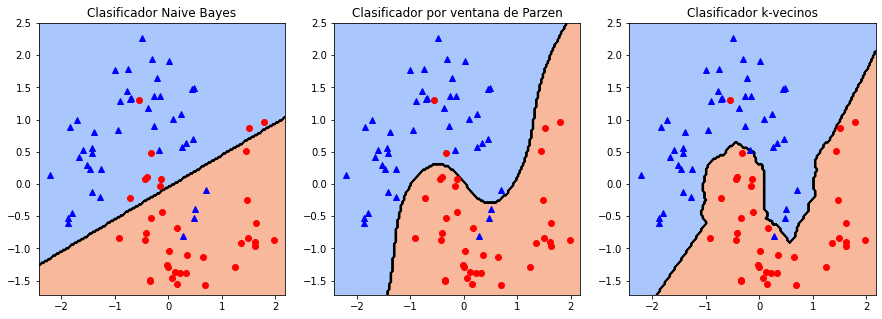

Usando el dataset make_circles


Precisión del clasificador Naive Bayes: 0.8625
Precisión del clasificador ventana de Parzen: 0.8125
Precisión del clasificador k-vecinos: 0.8125
----------------------------------------


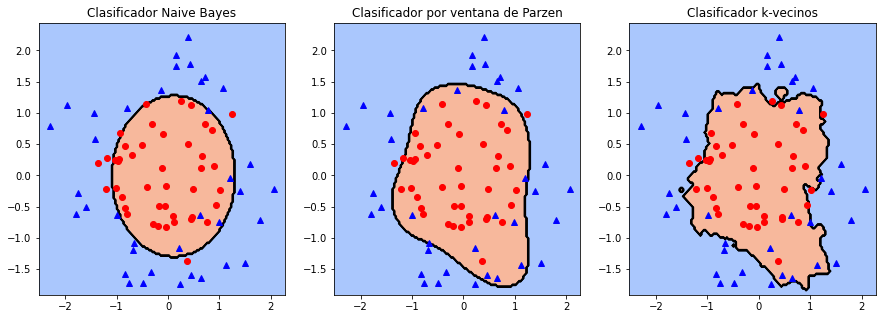

Usando el dataset make_blobs


Precisión del clasificador Naive Bayes: 0.8625
Precisión del clasificador ventana de Parzen: 0.8625
Precisión del clasificador k-vecinos: 0.85
----------------------------------------


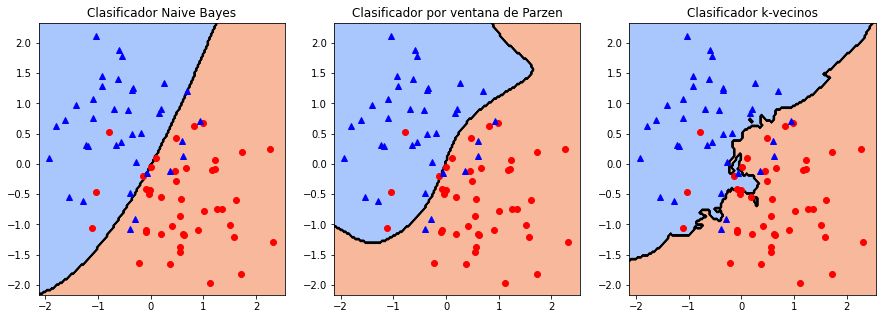

In [37]:
# Ahora se va a iterar cada clasificador en los diferentes datasets, donde se 
#plotean sus regiones de clasificación y el accuracy de cada clasificador

datasets_name = ['make_moons','make_circles','make_blobs']

for i, (X, y) in enumerate(datasets):
  
  # Preprocesar el dataset, diviendolo en entrenamiento y validación
  X = StandardScaler().fit_transform(X)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4)

  print('Usando el dataset ' + datasets_name[i])
  print('\n')

  #Clasificador gaussiano (Naive Bayes)
  gnb = GaussianNB()
  gnb = gnb.fit(X_train, y_train)
  y_pred = gnb.predict(X_test)
  
  print('Precisión del clasificador Naive Bayes: '+ str(accuracy_score(y_test,y_pred)))

  #Clasificador con el método de la ventana de Parzen (KDE)
  kde = KDEClassifier(bandwidth=0.5)
  kde = kde.fit(X_train, y_train)
  y_pred = kde.predict(X_test)

  print('Precisión del clasificador ventana de Parzen: ' + str(accuracy_score(y_test,y_pred)))

  #K vecinos mas cercanos
  kmeans = KNeighborsClassifier(n_neighbors=5)
  kmeans = kmeans.fit(X_train,y_train) 
  y_pred = kmeans.predict(X_test)

  print('Precisión del clasificador k-vecinos: ' + str(accuracy_score(y_test,y_pred)))
  print('-'*40)
  plotRegion(X_test,y_test,[gnb,kde,kmeans])

- De los resultados obtenidos podemos observar como el clasificador Naive Bayes presenta una frontera mas pareja respecto a los otros dos metodos de clasificación, esto debido a su construcción a partir de la formula de Bayes.

- En el Clasificador por ventana de Parzen vemos como la frontera se ajusta mejor a la naturaleza de nuestros datos, obtenienddo una mejor frontera para clasificar.

- Por ultimo, en el clasificador por vecinos mas cercanos vemos una frontera menos suave y pareja, en este clasificador se debe tener cuidado con el parametro del numero de vecinos a utilizar para la clasificación por que se puede sobreajustar el modelo a los datos de entrenamiento, y al momento de realizar una clasificación con información nueva podria no clasificar de manera adecuada.
